#### Imports

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Filtering and Combining Desired Reviews

In [3]:
# Load the combined reviews data from the saved file
combined_reviews_df = pd.read_csv('processed_data/combined_reviews.csv', encoding='utf-8', engine='python')

# Filter the reviews with 4 and 5 stars
frequent_items_reviews = combined_reviews_df[combined_reviews_df['rating'].isin([4, 5])]

# Load the positive reviews from the sentiment analysis on the 3-star reviews
positive_reviews_df = pd.read_csv('processed_data/3_star_positive_reviews.csv', encoding='utf-8', engine='python')

# Combine the filtered 4 and 5-star reviews with the 3-star positive reviews
frequent_items_reviews = pd.concat([frequent_items_reviews, positive_reviews_df], ignore_index=True)

print(f"Total reviews to be used in frequent items: {len(frequent_items_reviews)}")

Total reviews to be used in frequent items: 693706


In [4]:
# Check how many unique products there are based on 'product_id'
unique_products_count = frequent_items_reviews['product_id'].nunique()

# Pretty printing the result
print(f"Total number of unique products in the reviews dataset: {unique_products_count}")

Total number of unique products in the reviews dataset: 1547


## Frequent Items

Users per group:
2+ reviews: 117420 users
3+ reviews: 55361 users
4+ reviews: 30695 users
5+ reviews: 18753 users
6+ reviews: 12557 users
7+ reviews: 9009 users
8+ reviews: 6901 users
9+ reviews: 5534 users
10+ reviews: 4613 users
20+ reviews: 1574 users
30+ reviews: 825 users
40+ reviews: 458 users
50+ reviews: 256 users
60+ reviews: 138 users
70+ reviews: 77 users
80+ reviews: 34 users
90+ reviews: 13 users
100+ reviews: 7 users
110+ reviews: 6 users
120+ reviews: 4 users
130+ reviews: 2 users
140+ reviews: 1 users
150+ reviews: 1 users
160+ reviews: 1 users
170+ reviews: 1 users
180+ reviews: 1 users
190+ reviews: 1 users
200+ reviews: 1 users
210+ reviews: 0 users


/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


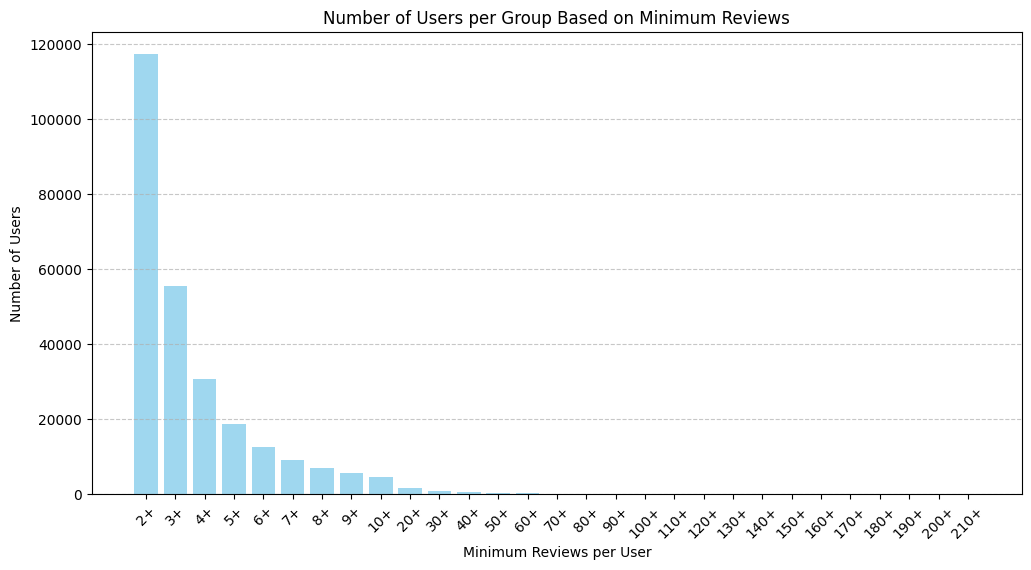

In [5]:
# Step 1: Aggregate reviews by user
user_review_counts = frequent_items_reviews.groupby('author_id')['product_id'].nunique()

# Step 2: Define thresholds for grouping
thresholds = list(range(2, 11)) + [20, 30] + list(range(40, user_review_counts.max() + 10, 10))

# Step 3: Count users per group
users_per_group = []

for t in thresholds:
    count = (user_review_counts >= t).sum()
    users_per_group.append(count)

# Step 4: Display results
print("Users per group:")
for t, count in zip(thresholds, users_per_group):
    print(f"{t}+ reviews: {count} users")

plt.figure(figsize=(12, 6))
plt.bar([str(t) + "+" for t in thresholds], users_per_group, color="skyblue", alpha=0.8)
plt.title("Number of Users per Group Based on Minimum Reviews")
plt.xlabel("Minimum Reviews per User")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

_____

In [6]:
# Selecting users with 10+ reviews
filtered_df = frequent_items_reviews.groupby('author_id').filter(lambda x: x['product_id'].nunique() > 9)

# Display the filtered DataFrame
print(f"Number of rows in the filtered dataframe: {len(filtered_df)}")
print(f"Number of unique authors in the filtered dataframe: {len(set(filtered_df['author_id']))}")
#set(filtered_df['author_id'])

Number of rows in the filtered dataframe: 95902
Number of unique authors in the filtered dataframe: 4613


In [7]:
# Combining all the products reviewed for each person in the dataset
selected_columns = filtered_df[['author_id', 'product_id']]

# Convert product_id to string before applying 'join'
combined_reviews = selected_columns.groupby('author_id')['product_id'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

print(combined_reviews)

            author_id                                         product_id
0          1000235057  P420652 P421275 P297524 P456412 P232903 P37584...
1         10003868106  P420652 P480612 P375849 P375853 P472468 P37585...
2          1001087549  P309308 P423688 P270594 P433520 P232915 P45621...
3         10015807972  P420652 P427419 P454380 P480612 P427406 P42741...
4         10021044780  P309308 P442840 P466123 P500633 P418346 P47641...
...               ...                                                ...
4608        998162812  P269122 P429952 P471237 P443833 P422022 P37970...
4609        998179876  P309308 P429952 P270594 P442840 P466123 P44779...
4610        998853649  P456398 P461159 P461933 P456213 P429242 P41561...
4611       9990263118  P430337 P427406 P431180 P440307 P410400 P45567...
4612  orderGen1698648  P443833 P428095 P455926 P502656 P446423 P45536...

[4613 rows x 2 columns]


In [8]:
"""def adaptive_support(df):
    # Adjust column names to match your DataFrame
    item_column = 'product_id'  # Replace with the correct column name for items
    transaction_column = 'author_id'  # Replace with the correct column name for transactions
    criteria_column = 'rating'  # Replace with the correct column name for criteria value

    # Extract unique items and their criteria values
    unique_items = df[item_column].unique()
    num_transactions = df[transaction_column].nunique()
    num_items = len(unique_items)

    # Initialize required dictionaries and variables
    support = {}  # S(d): support value for each item
    utility = {}  # U(d): utility value for each item
    criteria_values = df.groupby(item_column)[criteria_column].first()  # Assume criteria_value exists
    total_utility = 0  # Sum of utilities

    # Calculate support and utility for each item
    for item in unique_items:
        frequency = df[df[item_column] == item].shape[0]  # Count occurrences
        support[item] = frequency / num_transactions  # S(d) = n(d) / |D|
        utility[item] = support[item] * criteria_values[item]  # U(d) = S(d) * X(d)
        total_utility += utility[item]  # Sum = Sum + U(d)

    # Calculate average support and minimum threshold
    ave_sup = total_utility / num_items  # Avesup = Sum / |N|
    min_threshold = ave_sup / num_transactions  # Min_threshold = Avesup / |D|

    return ave_sup, min_threshold, support, utility

# Example usage
# combined_df should contain columns like 'product_id', 'author_id', and 'criteria_value'.
avesup, min_threshold, support, utility = adaptive_support(frequent_items_reviews)
print(f"Average Support (Avesup): {avesup}")
print(f"Minimum Threshold (Min_threshold): {min_threshold}")
print("Support values (S):", support)
print("Utility values (U):", utility)"""

'def adaptive_support(df):\n    # Adjust column names to match your DataFrame\n    item_column = \'product_id\'  # Replace with the correct column name for items\n    transaction_column = \'author_id\'  # Replace with the correct column name for transactions\n    criteria_column = \'rating\'  # Replace with the correct column name for criteria value\n\n    # Extract unique items and their criteria values\n    unique_items = df[item_column].unique()\n    num_transactions = df[transaction_column].nunique()\n    num_items = len(unique_items)\n\n    # Initialize required dictionaries and variables\n    support = {}  # S(d): support value for each item\n    utility = {}  # U(d): utility value for each item\n    criteria_values = df.groupby(item_column)[criteria_column].first()  # Assume criteria_value exists\n    total_utility = 0  # Sum of utilities\n\n    # Calculate support and utility for each item\n    for item in unique_items:\n        frequency = df[df[item_column] == item].shape[0] 

In [9]:
# Convert the 'reviews' into a list of transactions
transactions = combined_reviews['product_id'].str.split().tolist()

# Create a DataFrame for one-hot encoding
# Flatten all unique items (reviews) and create a unique item list
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True)

# Focus on frequent itemsets containing only a single product (not pairs or larger sets)
frequent_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 1]

# Generate association rules, with support as minimum of 3%
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.03, num_itemsets=len(frequent_itemsets))

print(frequent_pairs)

      support   itemsets
0    0.076956  (P232915)
1    0.053111  (P269122)
2    0.263169  (P270594)
3    0.183178  (P309308)
4    0.040321  (P379707)
..        ...        ...
190  0.047908  (P505049)
191  0.069586  (P505054)
192  0.036636  (P505139)
193  0.031216  (P505158)
194  0.033817    (P7880)

[195 rows x 2 columns]


In [10]:
# Filter rules to include only those where antecedents have a single item
rules_filtered = rules[rules['antecedents'].apply(len) == 1].copy()

rules_display = rules_filtered[["antecedents", "consequents", "support", "confidence", "lift"]].copy()

# Convert frozensets to readable strings
rules_display["antecedents"] = rules_display["antecedents"].apply(lambda x: ', '.join(list(x)))
rules_display["consequents"] = rules_display["consequents"].apply(lambda x: ', '.join(list(x)))

# Sorting by confidence
rules_display = rules_display.sort_values(by="support", ascending=False)
print(rules_display.to_string(index=False))

antecedents               consequents  support  confidence      lift
    P270594                   P500633 0.148277    0.563427  1.991638
    P500633                   P270594 0.148277    0.524138  1.991638
    P500633                   P503936 0.127249    0.449808  2.108706
    P503936                   P500633 0.127249    0.596545  2.108706
    P270594                   P503936 0.122263    0.464580  2.177954
    P503936                   P270594 0.122263    0.573171  2.177954
    P476414                   P500633 0.113809    0.531377  1.878345
    P500633                   P476414 0.113809    0.402299  1.878345
    P476414                   P270594 0.110774    0.517206  1.965299
    P270594                   P476414 0.110774    0.420923  1.965299
    P500633                   P500777 0.106005    0.374713  2.394113
    P500777                   P500633 0.106005    0.677285  2.394113
    P479841                   P500633 0.105571    0.605721  2.141144
    P500633                   P479

In [11]:
unique_values = pd.concat([rules_display['antecedents']]).nunique()
unique_values

82

## Testing

In [12]:
filtered_rules = rules_display[rules_display['antecedents'].apply(lambda x: 'P500633' in x)]
print(filtered_rules)

     antecedents                consequents   support  confidence      lift
101      P500633                    P270594  0.148277    0.524138  1.991638
881      P500633                    P503936  0.127249    0.449808  2.108706
605      P500633                    P476414  0.113809    0.402299  1.878345
855      P500633                    P500777  0.106005    0.374713  2.394113
735      P500633                    P479841  0.105571    0.373180  2.141144
...          ...                        ...       ...         ...       ...
2294     P500633  P270594, P503936, P400259  0.030349    0.107280  2.512087
2226     P500633           P503936, P503668  0.030349    0.107280  2.334345
2215     P500633           P503726, P501760  0.030132    0.106513  2.641647
876      P500633                    P503879  0.030132    0.106513  1.269629
2161     P500633           P482676, P501760  0.030132    0.106513  2.729702

[206 rows x 5 columns]


In [13]:
# Preprocess the rules DataFrame to ensure 'antecedents' and 'consequents' are sets
def preprocess_rules(rules):
    """
    Preprocess the rules DataFrame to ensure 'antecedents' and 'consequents' are sets.
    """
    rules['antecedents'] = rules['antecedents'].apply(lambda x: set(x.split()) if isinstance(x, str) else x)
    rules['consequents'] = rules['consequents'].apply(lambda x: set(x.split()) if isinstance(x, str) else x)
    return rules

# Function to find items associated with an input item
def find_associated_items(input_item, rules):
    """
    Find all items associated with an input item based on association rules.

    Parameters:
        input_item (str): The item to find associations for.
        rules (pd.DataFrame): A DataFrame of association rules with columns 'antecedents' and 'consequents'.

    Returns:
        set: A set of items associated with the input item.
    """
    associated_items = set()

    unique_values = pd.concat([rules_display['antecedents']]).nunique()

    # Iterate through the rules
    for _, rule in rules.iterrows():
        antecedents = rule['antecedents']
        consequents = rule['consequents']

        # Check if the input item is in the antecedents
        if input_item in antecedents:
            # Add all consequents to the associated items
            associated_items.update(consequents)

    return associated_items

rules_df = pd.DataFrame(filtered_rules)

# Preprocess the rules DataFrame
rules_df = preprocess_rules(rules_df)

# Input item
input_item = 'P500633'

# Find associated items
associated_items = find_associated_items(input_item, rules_df)
print(f"Items associated with '{input_item}': {associated_items}")

Items associated with 'P500633': {'P503814', 'P503936', 'P501288', 'P482551', 'P481989', 'P466123', 'P479841,', 'P471237,', 'P505024', 'P455236', 'P411365', 'P479348', 'P500618', 'P500777', 'P423148', 'P500288,', 'P458219', 'P500993', 'P501760', 'P456218', 'P503936,', 'P482540', 'P479327,', 'P482676', 'P503726,', 'P480613', 'P482676,', 'P309308', 'P479645', 'P442839', 'P483679', 'P503668', 'P504044', 'P270594,', 'P501254', 'P462666', 'P505049', 'P505020', 'P503879', 'P481739', 'P471046', 'P505031', 'P479645,', 'P483076', 'P505023,', 'P477157', 'P504125', 'P471043,', 'P479318', 'P503651', 'P505023', 'P476414', 'P423688,', 'P505031,', 'P479327', 'P433520', 'P232915', 'P400259', 'P480461', 'P479841', 'P270594', 'P474075', 'P482535', 'P423688', 'P423148,', 'P482551,', 'P471043', 'P479318,', 'P455236,', 'P503726', 'P500288', 'P500744', 'P474832', 'P470529', 'P476414,', 'P481830', 'P469538', 'P501760,', 'P423136', 'P418624', 'P442838', 'P471237', 'P481739,', 'P500777,', 'P505054', 'P481732',

### Download variables to use in reccomender notebook

In [17]:
# Save variables to a file
with open('rules_display.pkl', 'wb') as f:
    pickle.dump(rules_display, f)

with open('filtered_rules.pkl', 'wb') as f:
    pickle.dump(filtered_rules, f)